In [1]:
import pandas as pd
from scipy.io import arff
import torch
import numpy as np
import pickle as pkl
from matplotlib import pyplot as plt
from utils.misc_utils import test_uq, get_q_idx
from recal import iso_recal
import os

from sklearn.preprocessing import StandardScaler

In [16]:
def simple_moving_average(data, window_size=5):
    if len(data) < window_size:
        raise Exception("Window size cannot be larger than the data size.")
    
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def sort_and_smooth(cali_score, sharp_score, x):

    idx = np.argsort(cali_score)
    cali_score = cali_score[idx]
    sharp_score = sharp_score[idx]
    x_mask = (x> cali_score.min())*(x< cali_score.max())
    cali_score_even = x[x_mask]
    sharp_score_even = np.interp(cali_score_even, cali_score, sharp_score)
    window_size = 5
    sharp_score_even = simple_moving_average(sharp_score_even, window_size)
    cali_score_even = cali_score_even[window_size//2:window_size//2+len(sharp_score_even)]
    return cali_score_even, sharp_score_even


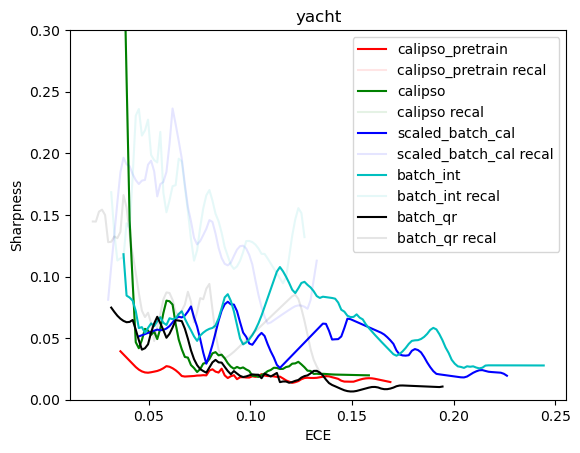

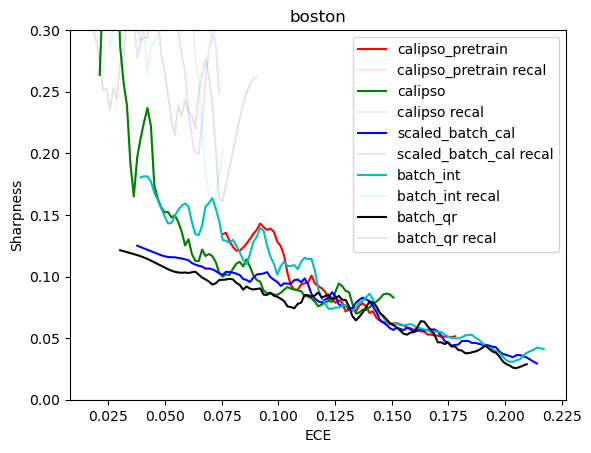

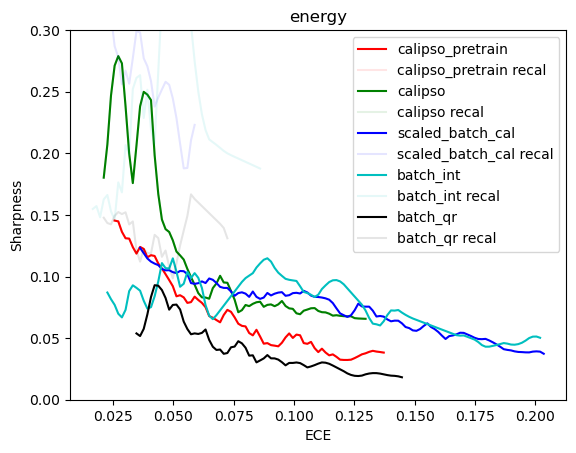

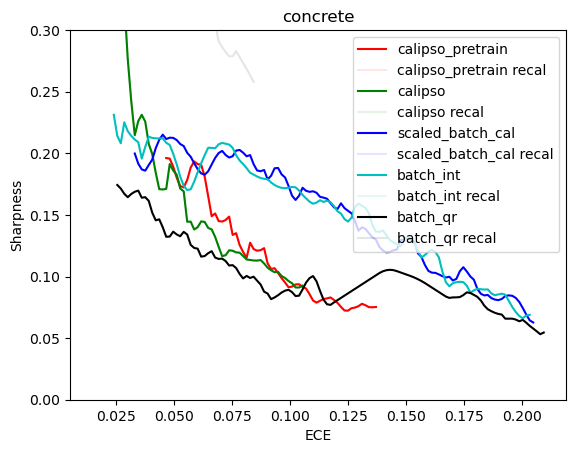

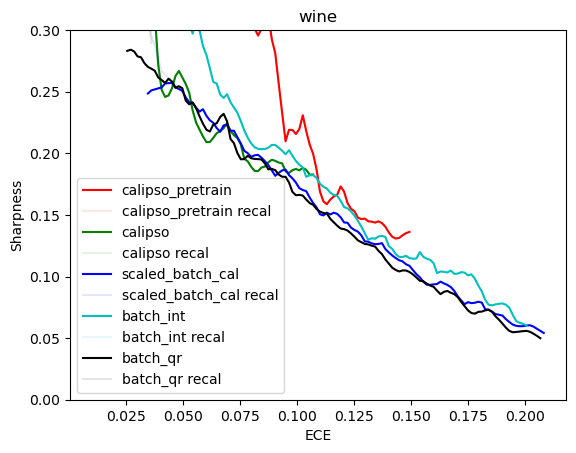

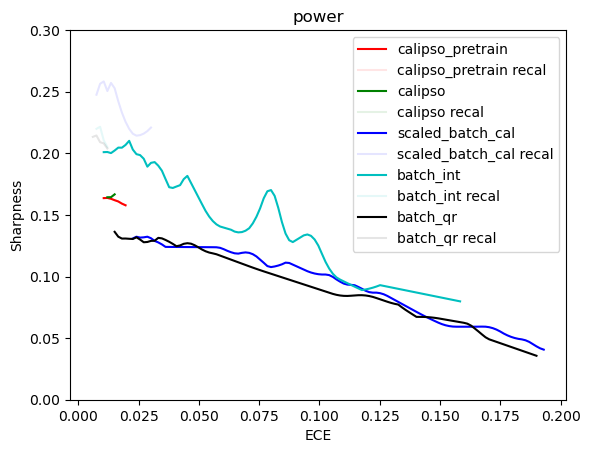

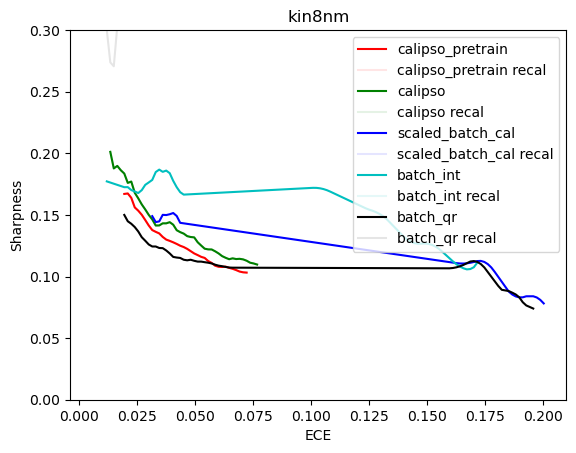

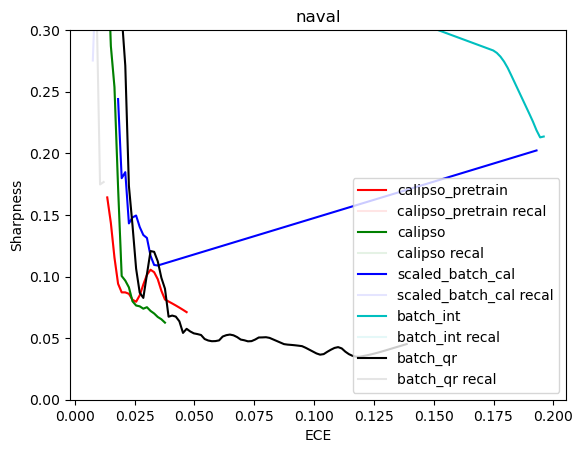

In [23]:

datasets=['yacht', 'boston', 'energy', 'concrete', 'wine', 'power', 'kin8nm', 'naval']
losses=["calipso_pretrain", "calipso", "scaled_batch_cal", "batch_int", "batch_qr"]
seeds= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# seeds= [0]
save_dir = os.getcwd()+ '/results'
num_ens = '1'
boot = 'False'
sharp_all = False
draw_group_every = '600'
colors = ['r', 'g', 'b', 'c', 'k']
x = np.linspace(0, 0.3, 200)
for data in datasets:
    plt.figure()
    for i, loss in enumerate(losses):
        te_cali_score = []
        te_sharp_score = []
        recal_te_cali_score = []
        recal_te_sharp_score = []
        for seed in seeds:
            # Save file name

            # Save file name
            if "penalty" not in loss:
                save_file_name = "{}/{}_loss{}_ens{}_boot{}_gdp{}_seed{}.pkl".format(
                    save_dir,
                    data,
                    loss,
                    num_ens,
                    boot,
                    draw_group_every,
                    seed,
                )
            else:
                # penalizing sharpness
                if sharp_all is not None and sharp_all:
                    save_file_name = "{}/{}_loss{}_pen{}_sharpall_ens{}_boot{}_gdp{}_seed{}.pkl".format(
                        save_dir,
                        data,
                        loss,
                        sharp_penalty,
                        num_ens,
                        boot,
                        draw_group_every,
                        seed,
                    )
                elif sharp_all is not None and not sharp_all:
                    save_file_name = "{}/{}_loss{}_pen{}_wideonly_ens{}_boot{}_gdp{}_seed{}.pkl".format(
                        save_dir,
                        data,
                        loss,
                        sharp_penalty,
                        num_ens,
                        boot,
                        draw_group_every,
                        seed,
                    )
            with open(save_file_name, 'rb') as f:
                results = pkl.load(f)

            te_cali_score.append(results['te_cali_score'])
            te_sharp_score.append(results['te_sharp_score'])
            recal_te_cali_score.append(results['recal_te_cali_score'])
            recal_te_sharp_score.append(results['recal_te_sharp_score'])
        try:
            te_cali_score = np.concatenate(te_cali_score)   
            te_sharp_score = np.concatenate(te_sharp_score)
            recal_te_cali_score = np.concatenate(recal_te_cali_score)
            recal_te_sharp_score = np.concatenate(recal_te_sharp_score)
        except:
            te_cali_score = np.array(te_cali_score)
            te_sharp_score = np.array(te_sharp_score)
            recal_te_cali_score = np.array(recal_te_cali_score)
            recal_te_sharp_score = np.array(recal_te_sharp_score)
        
        te_cali_score_even, te_sharp_score_even = sort_and_smooth(te_cali_score, te_sharp_score, x)
        recal_te_cali_score_even, recal_te_sharp_score_even = sort_and_smooth(recal_te_cali_score, recal_te_sharp_score, x)

        plt.plot(te_cali_score_even, te_sharp_score_even, colors[i], label=loss)
        plt.plot(recal_te_cali_score_even, recal_te_sharp_score_even, colors[i], alpha=0.1, label=loss+' recal')
    plt.title(data)
    plt.ylim(0, 0.3)
    plt.xlabel('ECE')
    plt.ylabel('Sharpness')
    plt.legend()
    plt.show()
            # save_dic = {
            #     "tr_loss_list": tr_loss_list,  # loss lists
            #     "va_loss_list": va_loss_list,
            #     "te_loss_list": te_loss_list,
            #     "va_cali_score": va_cali_score,  # test on va
            #     "va_sharp_score": va_sharp_score,
            #     "va_exp_props": va_exp_props,
            #     "va_obs_props": va_obs_props,
            #     "va_q_preds": va_q_preds,
            #     "te_cali_score": te_cali_score,  # test on te
            #     "te_sharp_score": te_sharp_score,
            #     "te_exp_props": te_exp_props,
            #     "te_obs_props": te_obs_props,
            #     "te_q_preds": te_q_preds,
            #     "te_g_cali_scores": te_g_cali_scores,
            #     "te_scoring_rules": te_scoring_rules,
            #     "recal_model": recal_model if args.recal else None,   # recalibration model
            #     "recal_exp_props": recal_exp_props if args.recal else None,
            #     "recal_va_cali_score": recal_va_cali_score if args.recal else None,
            #     "recal_va_sharp_score": recal_va_sharp_score if args.recal else None,
            #     "recal_va_obs_props": recal_va_obs_props if args.recal else None,
            #     "recal_va_q_preds": recal_va_q_preds if args.recal else None,
            #     "recal_va_g_cali_scores": recal_va_g_cali_scores if args.recal else None,
            #     "recal_va_scoring_rules": recal_va_scoring_rules if args.recal else None,
            #     "recal_te_cali_score": recal_te_cali_score if args.recal else None,
            #     "recal_te_sharp_score": recal_te_sharp_score if args.recal else None,
            #     "recal_te_obs_props": recal_te_obs_props if args.recal else None,
            #     "recal_te_q_preds": recal_te_q_preds if args.recal else None,
            #     "recal_te_g_cali_scores": recal_te_g_cali_scores if args.recal else None,
            #     "recal_te_scoring_rules": recal_te_scoring_rules if args.recal else None,
            #     "args": args,
            #     "model": model_ens,
            #     "best_models": best_models,
            #     "best_sharp_scores": best_sharp_scores,
            # }
